# NLP - Assignment 3
## HW Group 7

You have been provided a corpus of news articles. Your task is to identify prevalent topics by applying both LDA and BERTopic. To complete this assignment:

- Explain how you chose the number of topics for each approach, as well as any other pertinent hyperparameters. Include any relevant visualizations you used for selecting the number of topics.
- Interpret model results by assigning a label to each topic that represents what the topic is about (i.e. "Technology in healthcare", or "Computer Software"). You must provide some kind of evidence that (topic model outputs, random samples of data, etc) that your labels are sensible.
- Discuss the differences in the output between the two approaches.

In [1]:
import pandas as pd
import sys
import multiprocessing as mp
import spacy
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models import Phrases, LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

from umap import UMAP
from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_colwidth = None

In [2]:
url = "https://storage.googleapis.com/adsp-nlp-open/data/nlp_a_6_news.json"
news_df = pd.read_json(url, orient="records", lines=True).sample(n=5000, random_state=0)

In [3]:
news_df.sample(5)

url  \
2892                                                                          https://techcentral.co.za/telkom-mulls-towers-sale-after-pausing-swiftnet-listing/212273/   
5920  https://www.seattletimes.com/business/indonesia-malaysia-sign-accord-to-protect-migrant-workers/?utm_source=RSS&utm_medium=Referral&utm_campaign=RSS_nation-world   
4649                                                    https://www.wuwm.com/arts-culture/2022-01-21/whats-making-us-happy-a-guide-for-your-weekend-reading-and-viewing   
5529                                                                       https://myfox8.com/reviews/br/electronics-br/laptop-computers-br/the-best-lenovo-chromebook/   
3528                                                    https://www.etfdailynews.com/2022/04/20/canadian-pacific-railway-cp-to-release-quarterly-earnings-on-wednesday/   

           date language  \
2892 2022-06-15       en   
5920 2022-04-01       en   
4649 2022-01-22       en   
5529 2022-06-27       en   
3528 2022-04-20       en   

                                                                                                      title  \
2892                                  Telkom mulls towers sale after pausing Swiftnet listing - TechCentral   
5920                         Indonesia, Malaysia sign accord to protect migrant workers | The Seattle Times   
4649  What's making us happy: A guide for your weekend reading and viewing | WUWM 89.7 FM - Milwaukee's NPR   
5529                                                                 The best Lenovo Chromebook | FOX8 WGHP   
3528              Canadian Pacific Railway (CP) to Release Quarterly Earnings on Wednesday - ETF Daily News   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## Data Cleaning

In [4]:
import re

def strip_boilerplate(text):
    text = re.sub(r'https?://\S+', '', text)  # remove URLs
    text = re.sub(r'\b([A-Z][A-Z\s]{2,})\b', '', text)  # all caps phrases (e.g., section headers)
    text = re.sub(r'(Subscribe|Privacy Policy|Careers|Contact Us|All rights reserved|Disclaimer|Log In|Sign Up|Apps|Help)', '', text, flags=re.I)
    text = re.sub(r'[\n\r\t]', ' ', text)  # remove newlines/tabs
    text = re.sub(r'\s+', ' ', text)  # collapse whitespace
    return text.strip()

In [5]:
def clean_text(corpus, spacy_pipeline, as_string=True, n_proc=1, batch_size=1000):
    """
    Cleans a sequence of text by applying some simple processing techniques.

    Args:
        corpus (Iterable): a sequence of text to be processed
        spacy_pipeline: the Spacy pipeline object for processing text
        n_proc (int): the number of processors to use for parallel processing
        batch_size (int): the number of texts to process in a single batch

    Returns:
        clean_sequence (list): a cleaned version of the original text
    """
    # container to store cleaned documents
    corpus_clean = []

    for doc in spacy_pipeline.pipe(
        corpus,
        disable=["ner"],
        n_process=n_proc,
        batch_size=batch_size
    ):

        # container for cleaned document tokens
        doc_tokens = [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop and token.is_alpha and (len(token) > 1) and token.pos_ in ("NOUN", "VERB")
        ]
        
        if as_string:
            corpus_clean.append(" ".join(doc_tokens))
        else:
            corpus_clean.append(doc_tokens)

    return corpus_clean

In [6]:
# loading spacy model
SPACY_MODEL = "en_core_web_md"
nlp = spacy.load(SPACY_MODEL)

## LDA - Data Preprocessing

In [7]:
# Strip boilerplate
news_df["clean_input"] = news_df["text"].apply(strip_boilerplate)

# Use spacy cleaner
normalized_corpus = clean_text(
    corpus=news_df["clean_input"].tolist(),
    spacy_pipeline=nlp,
    as_string=False
)

In [8]:
# gensim expects each document to be a list of tokens, not a string
normalized_corpus[1]

['rise',
 'fall',
 'content',
 'rise',
 'falle',
 'sportsopinioncolumnsletter',
 'estatearchiveseventsclassifiedsadvertisecontacte',
 'update',
 'suspect',
 'assault',
 'cooperate',
 'authority',
 'got',
 'snake',
 'racer',
 'snake',
 'report',
 'way',
 'end',
 'season',
 'penalty',
 'haunt',
 'restaurant',
 'restaurant',
 'car',
 'crash',
 'official',
 'assemble',
 'emergency',
 'exercise',
 'sophomore',
 'make',
 'claim',
 'sprinter',
 'circuit',
 'judge',
 'retire',
 'year',
 'rise',
 'falljune',
 'stock',
 'trade',
 'price',
 'change',
 'lawn',
 'garden',
 'care',
 'company',
 'slash',
 'profit',
 'forecast',
 'year',
 'cent',
 'maker',
 'can',
 'soup',
 'cookie',
 'raise',
 'revenue',
 'forecast',
 'year',
 'maker',
 'signature',
 'technology',
 'announce',
 'expand',
 'partnership',
 'drugmaker',
 'say',
 'vaccine',
 'combine',
 'shot',
 'protection',
 'variant',
 'appear',
 'work',
 'maker',
 'datum',
 'storage',
 'device',
 'say',
 'review',
 'option',
 'separate',
 'flash',
 '

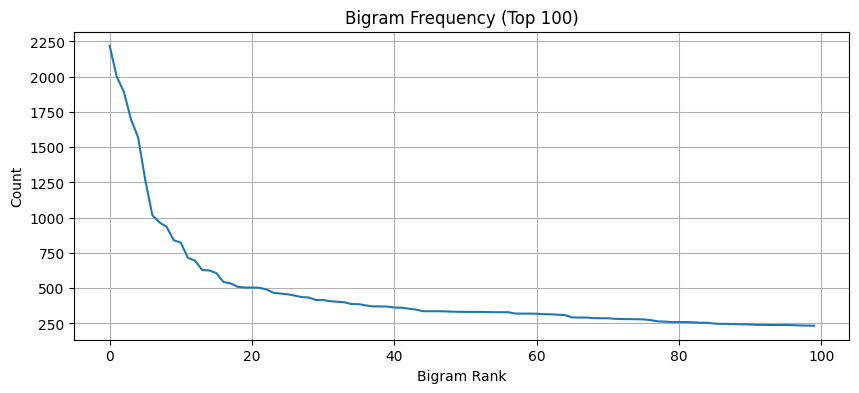

In [9]:
from gensim.models.phrases import Phrases, Phraser
from collections import Counter

# Train phrase model
phrase_model = Phrases(normalized_corpus, min_count=2, threshold=10)  # start with low threshold

# Count bigrams
bigram_counts = Counter()
for doc in normalized_corpus:
    for token in phrase_model[doc]:
        if "_" in token:
            bigram_counts[token] += 1

# Visualize frequency distribution
counts = list(bigram_counts.values())
counts.sort(reverse=True)

plt.figure(figsize=(10,4))
plt.plot(counts[:100])  # top 100 bigrams
plt.title("Bigram Frequency (Top 100)")
plt.xlabel("Bigram Rank")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [10]:
from pprint import pprint
pprint(bigram_counts.most_common(30))

[('open_tab', 2220),
 ('link_open', 2001),
 ('video_channel', 1893),
 ('music_video', 1697),
 ('logo_video', 1570),
 ('cookie_set', 1270),
 ('hand_corner', 1018),
 ('tab_link', 967),
 ('blog_post', 936),
 ('video_song', 841),
 ('need_know', 823),
 ('share_quarter', 715),
 ('supply_chain', 696),
 ('radioentertainmentmoviesbooksmusictheaterclassical_musictv', 629),
 ('interest_rate', 626),
 ('set_cookie', 607),
 ('cut_figure', 544),
 ('own_share', 534),
 ('press_release', 510),
 ('email_send', 505),
 ('research_report', 505),
 ('product_service', 503),
 ('find_deal', 492),
 ('cookie_store', 468),
 ('acquire_share', 462),
 ('stock_value', 457),
 ('post_comment', 448),
 ('sport_hq', 437),
 ('enter_email', 434),
 ('manage_subscription', 416)]


In [11]:
# training the phrases to find bigrams
# Set min_count = 10 according to eda
bigram_phraser = Phrases(normalized_corpus, min_count=10, threshold=10)

# adding bigrams to the original unigram data
for idx in range(len(normalized_corpus)):
    for phrase in bigram_phraser[normalized_corpus[idx]]:
        if '_' in phrase:
            # phrase is a bigram, add to document.
            normalized_corpus[idx].append(phrase)

In [12]:
# a dictiohary is the mapping of an id to a word
dictionary = Dictionary(normalized_corpus)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=0.01*len(normalized_corpus), no_above=0.5)

In [13]:
[(token, idx) for token, idx in dictionary.token2id.items()][:10]

[('accelerate', 0),
 ('achieve', 1),
 ('achieve_goal', 2),
 ('adapt', 3),
 ('addition', 4),
 ('address', 5),
 ('adopt', 6),
 ('advantage', 7),
 ('agreement', 8),
 ('aim', 9)]

In [14]:
corpus = [dictionary.doc2bow(doc) for doc in normalized_corpus]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 4163
Number of documents: 5000


## LDA - Modeling

In [15]:
# Lightweight settings
passes = 3
iterations = 100
eval_every = 5
chunksize = 200
min_topics = 5
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics + 1, step_size)

# Store coherence scores
coherence_scores = []

for num_topics in topics_range:
    model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=passes,
        iterations=iterations,
        eval_every=eval_every,
        chunksize=chunksize,
        random_state=42
    )

    coherence_model = CoherenceModel(
        model=model,
        texts=normalized_corpus,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f"Topics: {num_topics} \t Coherence Score: {coherence_score:.4f}")

Topics: 5 	 Coherence Score: 0.5453
Topics: 6 	 Coherence Score: 0.5467
Topics: 7 	 Coherence Score: 0.5618
Topics: 8 	 Coherence Score: 0.5856
Topics: 9 	 Coherence Score: 0.5891
Topics: 10 	 Coherence Score: 0.5845
Topics: 11 	 Coherence Score: 0.5857
Topics: 12 	 Coherence Score: 0.5815
Topics: 13 	 Coherence Score: 0.5838
Topics: 14 	 Coherence Score: 0.5803
Topics: 15 	 Coherence Score: 0.5958


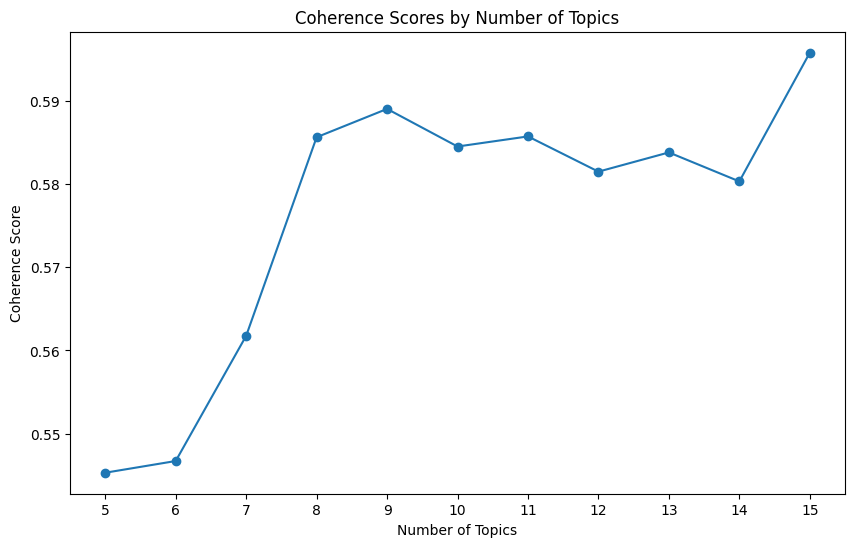

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(topics_range, coherence_scores, marker='o')
plt.title("Coherence Scores by Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.xticks(topics_range)
plt.show()

In [51]:
RANDOM_STATE = 0
num_topics = 15
chunksize = 200
passes = 3
iterations = 100
eval_every = 5

model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    chunksize=chunksize,
    alpha="auto",
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=RANDOM_STATE
)

In [52]:
model.show_topics(num_words=20)

[(0,
  '0.020*"account" + 0.019*"minute" + 0.019*"sign" + 0.019*"provide" + 0.018*"datum" + 0.015*"article" + 0.015*"delay" + 0.014*"price" + 0.014*"password" + 0.014*"member" + 0.013*"option" + 0.012*"visit" + 0.012*"fall" + 0.012*"author" + 0.012*"information" + 0.011*"profile" + 0.011*"view" + 0.011*"week" + 0.011*"market" + 0.010*"member_sign"'),
 (12,
  '0.018*"radioentertainmentmoviesbooksmusictheaterclassical" + 0.018*"musictv" + 0.017*"story" + 0.015*"advertising" + 0.014*"radioentertainmentmoviesbooksmusictheaterclassical_musictv" + 0.011*"pm" + 0.011*"information" + 0.011*"archive" + 0.011*"abortion" + 0.010*"comment" + 0.010*"win" + 0.010*"read" + 0.010*"staff" + 0.009*"term" + 0.009*"relate" + 0.009*"state" + 0.009*"community" + 0.009*"staffcommunitynewspaper" + 0.009*"taltonjobsautoshome" + 0.009*"condottaon"'),
 (8,
  '0.079*"open" + 0.052*"tab" + 0.049*"link" + 0.025*"link_open" + 0.024*"open_tab" + 0.021*"email" + 0.016*"join" + 0.015*"podcast" + 0.015*"window" + 0.014*

In [48]:
document_topics = [model.get_document_topics(doc) for doc in corpus]

news_df["text_clean"] = normalized_corpus
news_df["topics"] = document_topics

In [49]:
with pd.option_context("display.max_colwidth", 200):
    display(news_df)

,url,date,language,title,text,clean_input,dominant_topic,topic_label,text_clean,topics
3844,https://www.kxii.com/prnewswire/2022/05/23/computex-2022-global-press-conference-industry-leaders-gather-unlock-future-trends/,2022-05-23,en,COMPUTEX 2022 Global Press Conference Industry Leaders Gather to Unlock Future Trends,COMPUTEX 2022 Global Press Conference Industry Leaders Gather to Unlock Future TrendsSkip to contentTexoma LocalExpert AdviceTexoma EatsNewsWeatherSportsSend Us Your News TipWatch LiveSearchHomepa...,2022 Global Press Conference Industry Leaders Gather to Unlock Future TrendsSkip to contentTexoma LocalExpert AdviceTexoma EatsNewsWeatherSportsSend Us Your News TipWatch LiveSearchHomepageLivestr...,5,Economics & Technology Solutions,"[gather, contenttexoma, eatsnewsweathersportssend, livesearchhomepagelivestreamnewstexasoklahomaregionalinternationalnationalfireaccidentscrimeeducationsend, news, result, watch, bureaupowernation...","[(4, 0.02759195), (11, 0.08088271), (14, 0.8878019)]"
3617,https://www.bigrapidsnews.com/business/article/Moderna-Roku-rise-Scotts-Miracle-Gro-Charles-17228702.php,2022-06-09,en,"Moderna, Roku rise; Scotts Miracle-Gro, Charles River fall","Moderna, Roku rise; Scotts Miracle-Gro, Charles River fall Skip to main content Big Rapids Pioneer HomepageCurrently ReadingModerna, Roku rise; Scotts Miracle-Gro, Charles River fallSubscri...","Moderna, Roku rise; Scotts Miracle-Gro, Charles River fall Skip to main content Big Rapids Pioneer HomepageCurrently ReadingModerna, Roku rise; Scotts Miracle-Gro, Charles River falle-EditionSign ...",13,News & Weather,"[rise, fall, content, rise, falle, sportsopinioncolumnsletter, estatearchiveseventsclassifiedsadvertisecontacte, update, suspect, assault, cooperate, authority, got, snake, racer, snake, report, w...","[(2, 0.01487274), (3, 0.052018534), (4, 0.2651581), (5, 0.25174862), (6, 0.015971672), (10, 0.14275853), (11, 0.15994106), (13, 0.06607803), (14, 0.028515777)]"
2608,https://www.devdiscourse.com/article/education/2000652-create-entrepreneurship-ecosystem-in-districts-to-drive-local-jobs-ktaka-task-force-to-govt,2022-04-12,en,Create entrepreneurship ecosystem in districts to drive local jobs: K'taka task force to govt | Education,Create entrepreneurship ecosystem in districts to drive local jobs: K'taka task force to govt | Education HOME NEWS RESEARCH LIVE DISCOURSE BLOG / OPINION SUBMIT PRESS RE...,Create entrepreneurship ecosystem in districts to drive local jobs: K'taka task force to govt | Education / About Career Advertisement Team Partnership Knowledge Partnership Media Partnership / Ag...,3,Employment & Government,"[create, entrepreneurship, ecosystem, district, drive, job, force, govt, create, entrepreneurship, ecosystem, district, drive, job, force, govt, update, create, image, entrepreneurship, ecosystem,...","[(1, 0.35077882), (3, 0.014766482), (4, 0.3243738), (5, 0.026152276), (7, 0.06471838), (14, 0.21660458)]"
3857,https://www.seattletimes.com/seattle-news/health/connecticut-senate-oks-bill-that-protects-abortion-providers/?utm_source=RSS&utm_medium=Referral&utm_campaign=RSS_all,2022-04-30,en,Connecticut Senate OKs bill that protects abortion providers | The Seattle Times,Connecticut Senate OKs bill that protects abortion providers | The Seattle Times Skip to contentCoronavirusLocal NewsTraffic LabLaw & JusticeLocal PoliticsEducationEducation LabEastsideEnvironme...,Connecticut Senate OKs bill that protects abortion providers | The Seattle Times Skip to contentCoronavirusLocal NewsTraffic LabLaw & JusticeLocal PoliticsEducationEducation LabEastsideEnvironment...,1,Current Events & Society,"[ok, bill, protect, abortion, provider, radioentertainmentmoviesbooksmusictheaterclassical, musictv, estateopinioneditorialsletter, labeastsideenvironmentnorthwestdatahealthtime, schoolsmarinersso...","[(1, 0.075289086), (4, 0.18548118), (5, 0.068942204), (12, 0.6148825), (14, 0.05129293)]"
1595,https://www.breakinglatest.news/news/maturity-thanks-f

In [53]:
# Prepare the visualization
vis_data = gensimvis.prepare(model, corpus, dictionary)

# display
pyLDAvis.display(vis_data)

## BERTopic

In [18]:
RANDOM_STATE = 0
embedding_model = SentenceTransformer("thenlper/gte-small")
umap_model = UMAP(n_components=20, min_dist=0.0, metric='cosine', random_state=RANDOM_STATE)
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom')
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2))
ctfidf_model = ClassTfidfTransformer()

In [19]:
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
)

In [20]:
normalized_corpus_str = [" ".join(tokens) for tokens in normalized_corpus]
topics, probs = topic_model.fit_transform(normalized_corpus_str)
topic_info = topic_model.get_topic_info()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [21]:
# Truncate the "Representation" column for display
topic_info["Representation"] = topic_info["Representation"].apply(lambda x: ", ".join(x[:8]) + "..." if isinstance(x, list) else str(x)[:60] + "...")
topic_info["Representative_Docs"] = topic_info["Representative_Docs"].apply(
    lambda x: x[:100] + "..." if isinstance(x, str) else str(x)[:100] + "..."
)
display(topic_info)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1686,-1_say_year_market_company,"say, year, market, company, include, hour, time, report...",['consumer consumer product experience professional professional reward program solution profile inv...
1,0,219,0_share_rating_quarter_stock,"share, rating, quarter, stock, company, analyst, share quarter, buy...",['share buy contenthomeaboutnewsletterprivacycontact analyst ratingsdividendsearningsguidancehigh sh...
2,1,211,1_game_gaming_play_player,"game, gaming, play, player, open, console, release, video game...",['want miss cardsramssdscomputer tipssoftwareoperate cardsramssdscomputer tipssoftwareoperate system...
3,2,195,2_link open_link_open tab_tab,"link open, link, open tab, tab, open, link_open, tab link, tab_link...",['content podcast podcast mom people day search join join profile email preference newsletter manage...
4,3,175,3_inflation_rate_say_hike,"inflation, rate, say, hike, recession, rise, price, oil...",['discuss say look resultsbnnare look opinionetfsexecutivepursuitsinternationalmarket callscheduleli...
...,...,...,...,...,...
66,65,16,65_trade_trade dollar_dollar trade_dollar,"trade, trade dollar, dollar trade, dollar, trade trade, trade_dollar, trade_dollar trade_trade, trade_trade dollar_trade...",['day volume reach contenthomeaboutnewsletterprivacycontact analyst ratingsdividendsearningsguidance...
67,66,15,66_tablet_hour_screen_buy sell,"tablet, hour, screen, buy sell, device, need, need_know, need know...",['accessory read enter search term focus find killer house identify panel say fail deliver min offic...
68,67,15,67_nacho_laura_toni_casa,"nacho, laura, toni, casa, toni toni, en, zerboni, nacho nacho...",['principalbuscarbúsqueda por localesel tiempovideosrespondeentretenimientocoronavirus vivocompartec...
69,68,15,68_market_presswire_growth_client,"market, presswire, growth, client, industry, report, business, distribution...",['presswire work testimonial overview medium feature agricultureairlineautomotivebankingbook publish...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


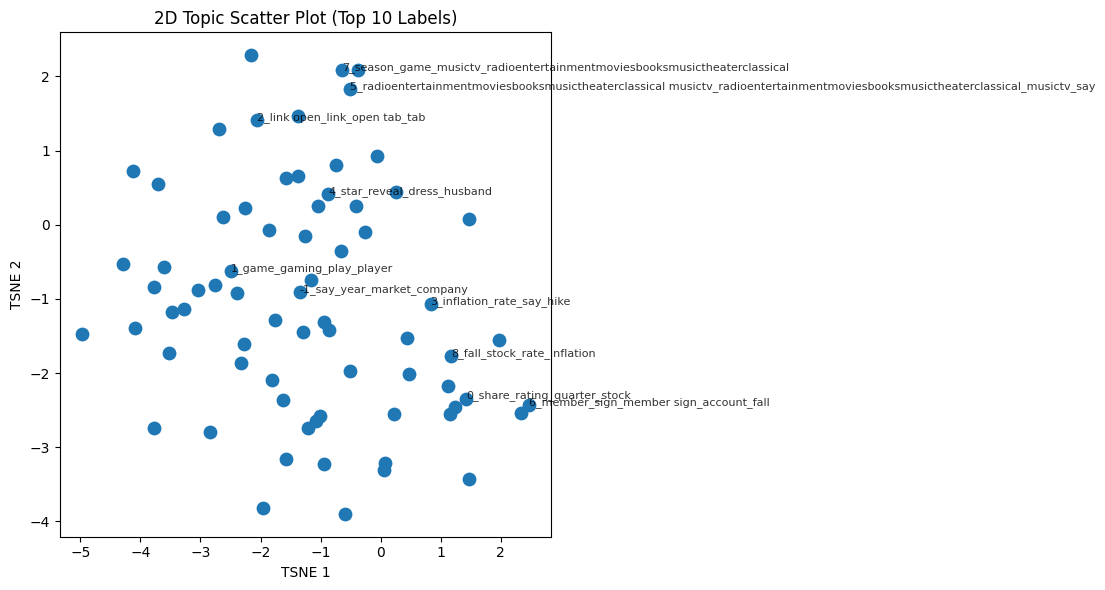

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced = tsne.fit_transform(topic_model.topic_embeddings_)

top_n = 10  # top N by count
top_topics = topic_info.sort_values("Count", ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], s=80)

# Add labels only for top topics
for idx in top_topics.index:
    x, y = reduced[idx]
    label = topic_info.loc[idx, "Name"]
    plt.text(x, y, label, fontsize=8, alpha=0.8)

plt.title("2D Topic Scatter Plot (Top 10 Labels)")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.tight_layout()
plt.show()

## Explain how you chose the number of topics for each approach, as well as any other pertinent hyperparameters. 
Include any relevant visualizations you used for selecting the number of topics.

- **Preprocessing: Bigrams & min_count Selection** <br>
During preprocessing, we used Gensim’s Phrases model to identify meaningful bigrams. To determine the appropriate min_count, we firstly plotted bigram frequencies and found a steep drop-off after the top 50. Based on this, I set **min_count=10** to ensure that only statistically meaningful and frequently occurring bigrams were retained.<br>

- **LDA: Number of Topics via Coherence Score** <br>
For LDA, we evaluated models with topic numbers ranging from 5 to 15 using the c_v coherence score. The plot in the "LDA - Modeling" section shows coherence trends. Given the graph, we selected 9 topics for the final LDA model.

- **BERTopic: Automatic Topic Discovery** <br>
The number of topics was determined automatically by clustering. We retained top 10–15 topics based on frequency and interpretability. Visualization using t-SNE and inspection of representative documents helped validate topic coherence. We also used customized pipeline for BERTopic (MiniLM embeddings; UMAP (15 neighbors, min_dist = 0.1); HDBSCAN (min_cluster_size = 15))

## Interpret model results by assigning a label to each topic that represents what the topic is about
(i.e. "Technology in healthcare", or "Computer Software"). You must provide some kind of evidence that (topic model outputs, random samples of data, etc) that your labels are sensible.

### LDA Model Interpretation

In [54]:
for idx, topic in model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.020*"account" + 0.019*"minute" + 0.019*"sign" + 0.019*"provide" + 0.018*"datum" + 0.015*"article" + 0.015*"delay" + 0.014*"price" + 0.014*"password" + 0.014*"member"
Topic 1: 0.013*"people" + 0.011*"go" + 0.011*"think" + 0.010*"know" + 0.009*"way" + 0.009*"employee" + 0.009*"look" + 0.008*"need" + 0.007*"point" + 0.007*"thing"
Topic 2: 0.057*"product" + 0.034*"menu" + 0.029*"care" + 0.025*"search" + 0.023*"icon" + 0.020*"form" + 0.018*"transform" + 0.016*"support" + 0.014*"accessory" + 0.014*"child"
Topic 3: 0.013*"star" + 0.011*"reveal" + 0.009*"look" + 0.009*"logo" + 0.008*"share" + 0.008*"show" + 0.007*"dress" + 0.007*"husband" + 0.007*"child" + 0.006*"daughter"
Topic 4: 0.014*"hour" + 0.011*"week" + 0.009*"government" + 0.008*"report" + 0.008*"state" + 0.007*"country" + 0.007*"month" + 0.007*"people" + 0.006*"case" + 0.006*"city"
Topic 5: 0.032*"video" + 0.014*"song" + 0.013*"music" + 0.009*"channel" + 0.009*"history" + 0.008*"shoot" + 0.007*"police" + 0.007*"kill" + 0.0

In [55]:
# Manually labeled LDA topic names based on top keywords
lda_topic_labels = {
    0: "Productivity Tools & Accounts",            
    1: "Current Events & Society",                 
    2: "E-commerce & Devices",                     
    3: "Crime & Celebrity Legal News",             
    4: "Inflation & Market Outlook",                
    5: "Crime & Safety News",                      
    6: "Web Tracking & Cookies",                   
    7: "User Interface & Links",                   
    8: "News & Weather",                           
    9: "Gaming & Entertainment",                   
    10: "Software Usage & Features",               
    11: "Stock Market Trends & Earnings",          
    12: "Entertainment & Digital Media",           
    13: "Stock Analysis & Financial Commentary",   
    14: "Economics & Technology Solutions"         
}

In [56]:
# Get dominant topic for each document
def get_dominant_topic(lda_model, corpus):
    topic_assignments = []
    for doc in corpus:
        topic_probs = lda_model.get_document_topics(doc)
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        topic_assignments.append(dominant_topic)
    return topic_assignments

# Apply to sample corpus
dominant_topics = get_dominant_topic(model, corpus)

In [57]:
news_df["dominant_topic"] = dominant_topics
news_df["topic_label"] = news_df["dominant_topic"].map(lda_topic_labels)

# Show random samples per topic
for topic_id, label in lda_topic_labels.items():
    print(f"\nTopic {topic_id} - {label}")
    sample_docs = news_df[news_df["dominant_topic"] == topic_id]["text"].sample(n=2, random_state=42)
    for i, doc in enumerate(sample_docs, 1):
        print(f"\n--- Sample {i} ---\n{doc[:500]}...\n")


Topic 0 - Productivity Tools & Accounts

--- Sample 1 ---
Evoke Pharma (EVOK) falls 2.88% in Light Trading on January 27 | Equities News Financial Markets by TradingViewPreviousNext Login  Register ×Equities.com member already? Sign in hereSign in with your social account? facebook twitter Password does not matchNot on Equities.com yet?Your Full Name:Username:E-Mail Address:Password:Confirm Password:Subscribe to Equities Newsletter: Register Verification code was sent to your e-mail address .Confirm Registration Try Again ×Don't have an Account? Regist...


--- Sample 2 ---
Olympic Steel (ZEUS) gains 9.29% for March 3 | Equities News Financial Markets by TradingViewPreviousNext Login  Register ×Equities.com member already? Sign in hereSign in with your social account? facebook twitter Password does not matchNot on Equities.com yet?Your Full Name:Username:E-Mail Address:Password:Confirm Password:Subscribe to Equities Newsletter: Register Verification code was sent to your e-mail addres

**LDA Topic Labeling and Interpretation** <br>
<br>
To interpret the latent topics generated by our LDA model, we assigned descriptive labels to each topic by examining the top weighted words in each topic (based on the LDA model output). After then, we then random sample documents associated with each topic, as seen in the sampling results above, to see if the labels are sensible. <br>
<br>
Given the sampling results, the assigned topic labels **appear sensible** based on the representative samples. The consistent alignment between top keywords and randomly sampled texts provides strong evidence that the topics are interpretable and thematically coherent. But there are also areas for improvement. A few topics (e.g., those with vague or generic keywords like “use,” “way,” “add”) were harder to label precisely, and it could be improved if we refined preprocessing steps (e.g., removing navigation metadata and template text), or applied more advanced coherence metrics during model selection.

### BERTopic Model Interpretation

In [ ]:
# Display BERTopic top 10 topics
top_topics

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1686,-1_say_year_market_company,"say, year, market, company, include, hour, time, report...",['consumer consumer product experience professional professional reward program solution profile inv...
1,0,219,0_share_rating_quarter_stock,"share, rating, quarter, stock, company, analyst, share quarter, buy...",['share buy contenthomeaboutnewsletterprivacycontact analyst ratingsdividendsearningsguidancehigh sh...
2,1,211,1_game_gaming_play_player,"game, gaming, play, player, open, console, release, video game...",['want miss cardsramssdscomputer tipssoftwareoperate cardsramssdscomputer tipssoftwareoperate system...
3,2,195,2_link open_link_open tab_tab,"link open, link, open tab, tab, open, link_open, tab link, tab_link...",['content podcast podcast mom people day search join join profile email preference newsletter manage...
4,3,175,3_inflation_rate_say_hike,"inflation, rate, say, hike, recession, rise, price, oil...",['discuss say look resultsbnnare look opinionetfsexecutivepursuitsinternationalmarket callscheduleli...
5,4,154,4_star_reveal_dress_husband,"star, reveal, dress, husband, look, say, daughter, wife...",['sell holiday home showbizaustraliafemailhealthsciencemoneyvideotravelshopdailymailtvheadline day h...
6,5,146,5_radioentertainmentmoviesbooksmusictheaterclassical musictv_radioentertainmentmoviesbooksmusictheaterclassical_musictv_say,"radioentertainmentmoviesbooksmusictheaterclassical musictv, radioentertainmentmoviesbooksmusictheaterclassical, musictv, say, radioentertainmentmoviesbooksmusictheaterclassical_musictv, advertising, story, service...",['fame base architect die age radioentertainmentmoviesbooksmusictheaterclassical musictv estateopini...
7,6,123,6_member_sign_member sign_account_fall,"member_sign, member sign, account, fall, sign, minute delay, price datum, author...",['fall member sign heresign account matchnot password confirm code send mail address registration re...
8,7,98,7_season_game_musictv_radioentertainmentmoviesbooksmusictheaterclassical,"season, game, musictv, radioentertainmentmoviesbooksmusictheaterclassical, radioentertainmentmoviesbooksmusictheaterclassical musictv, radioentertainmentmoviesbooksmusictheaterclassical_musictv, coach, icon...",['score carry radioentertainmentmoviesbooksmusictheaterclassical musictv estateopinioneditorialslett...
9,8,72,8_fall_stock_rate_inflation,"fall, stock, rate, inflation, market, rise, investor, index...",['stock recover investor jump sell weather closing weather closing delaysmenusearch sitewatch livewa...


In [ ]:
# Manual topic labeling for top 10 topics
manual_labels = {
    0: "Stock Market News & Trends",                       
    1: "Gaming & Esports",                                
    2: "Web Navigation & UI Elements",                     
    3: "Inflation & Economic Outlook",                     
    4: "Celebrity & Lifestyle",                            
    5: "Entertainment & Arts",                             
    6: "User Accounts & Memberships",                      
    7: "TV Shows & Streaming",                             
    8: "Stock Performance & Risk Sentiment",              
    -1: "Outliers / Uncategorized",                      
}

# Assign "Other" to remaining topics
all_topic_ids = list(set(topic_info['Topic']))
topic_labels = {
    topic_id: manual_labels.get(topic_id, "Other")
    for topic_id in all_topic_ids
}

topic_info['Label'] = topic_info['Topic'].map(topic_labels)

In [ ]:
import random

# Create a DataFrame for the document-level topic assignments
docs_df = pd.DataFrame({
    "Document": normalized_corpus_str,
    "Topic": topics
})

# Map labels onto the documents
docs_df["Label"] = docs_df["Topic"].map(topic_labels)

# Randomly sample 2 documents per label
for label in sorted(docs_df["Label"].unique()):
    subset = docs_df[docs_df["Label"] == label]["Document"]
    if len(subset) >= 2:
        samples = random.sample(list(subset), 2)
    else:
        samples = list(subset)
    
    print("="*60)
    print(f"Label: {label}")
    for i, sample in enumerate(samples, 1):
        print(f"--- Sample {i} ---")
        print(sample[:400])

Label: Celebrity & Lifestyle
--- Sample 1 ---
tell year ticket loser jail month day people die zelensky slam refusal establish fly zone say give light carry attack declare ceasefire mariupolcnn stop broadcast threat lock journalist year suspend operation slam attack plant threaten year prison spread information distance war crime tweet quake boot travel week display strength unity ally warn invasion go fly zone mean know voter fraud stare fac
--- Sample 2 ---
accuse assault inmate time jail transferskip rise livesponsore enter search term politicswashingtoninsurrectionflash pointtechnologycoronavirusunite hold hearing min introduce bill military min agree pay follow min screed plagiarize expert hour traffic mapkfor watch event traffic map prepare earn day earn day stun sooner win day announce day newsletterslinkslink see seniorsokc kitchenrecipeswhat s
Label: Entertainment & Arts
--- Sample 1 ---
activist urge athlete speak radioentertainmentmoviesbooksmusictheaterclassical musictv est

**BERTopic Labeling and Interpretation** <br>
<br>
To interpret the latent topics generated by our BERTopic model, we firstly focused on the top 10 most frequent topics and manually labeled them based on semantic patterns in both keywords and topic names. The remaining less frequent topics were grouped under the label "Other" for simplicity. <br> 
<br> 
To validate our topic assignments, we then randomly sampled two documents from each labeled topic. These samples allowed us to qualitatively assess whether the content aligns with the assigned label. <br> 
<br> 
Given the sampling results, the assigned topic labels appear sensible. For example, the topic labeled "Stock Performance & Risk Sentiment", includes documents that stock recover and its impacts. This consistent alignment between top keywords and real sample content demonstrates that the topics are both interpretable and thematically coherent. However, if further adjustments could be made, such as assigning label to the less frequent topics, the interpretability could increase

## Discuss the differences in the output between the two approaches.

#### **Observations**
**Topic Coherence**  
LDA topics sometimes had overlapping terms (e.g., "data", "use", "technology" in multiple topics), making labeling more ambiguous.

**BERTopic Advantage**  
BERTopic discovered finer-grained topics with clearly distinct terms like "covid vaccine", "streaming services", and "AI models".

**Human Interpretability**  
Using `.get_topic_info()` and `.get_representative_docs()`, BERTopic made it easier to understand and label each topic using actual examples from the corpus.

#### **Conclusion**
Both LDA and BERTopic provide valuable insights, but for this news dataset with diverse short-to-medium-length documents, BERTopic is more effective at generating interpretable and distinct topics. LDA is a great baseline, especially for fast iteration, but semantic models like BERTopic outperform when document meaning and nuance matter.
